In [1]:
# Download data and extract into path/data

# %%capture

# !wget -P data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
# !unzip -n data/train-test-data.zip -d data

In [4]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

import cv2
import torch
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
keypoints_frame = pd.read_csv('data/training_frames_keypoints.csv')

In [6]:
keypoints_frame = pd.read_csv('data/training_frames_keypoints.csv')

In [7]:
keypoints_frame.head()

Unnamed: 0     0     1     2      3     4      5     6  \
0           Luis_Fonsi_21.jpg  45.0  98.0  47.0  106.0  49.0  110.0  53.0   
1       Lincoln_Chafee_52.jpg  41.0  83.0  43.0   91.0  45.0  100.0  47.0   
2       Valerie_Harper_30.jpg  56.0  69.0  56.0   77.0  56.0   86.0  56.0   
3         Angelo_Reyes_22.jpg  61.0  80.0  58.0   95.0  58.0  108.0  58.0   
4  Kristen_Breitweiser_11.jpg  58.0  94.0  58.0  104.0  60.0  113.0  62.0   

       7     8  ...   126    127    128    129   130    131   132    133  \
0  119.0  56.0  ...  83.0  119.0   90.0  117.0  83.0  119.0  81.0  122.0   
1  108.0  51.0  ...  85.0  122.0   94.0  120.0  85.0  122.0  83.0  122.0   
2   94.0  58.0  ...  79.0  105.0   86.0  108.0  77.0  105.0  75.0  105.0   
3  120.0  58.0  ...  98.0  136.0  107.0  139.0  95.0  139.0  91.0  139.0   
4  121.0  67.0  ...  92.0  117.0  103.0  118.0  92.0  120.0  88.0  122.0   

    134    135  
0  77.0  122.0  
1  79.0  122.0  
2  73.0  105.0  
3  85.0  136.0  
4  84.0  122.0  

[5 rows x 137 columns]

In [8]:
# select an image by index n
n = 0
image_name = keypoints_frame.iloc[n, 0]
keypoints = keypoints_frame.iloc[n, 1:]
# change from pandas series to numpy array, reshape to (num_keypoints, 2)
keypoints = keypoints.values.reshape(-1, 2)
print(image_name)
print(keypoints.shape)


Luis_Fonsi_21.jpg
(68, 2)


(192, 176, 4)


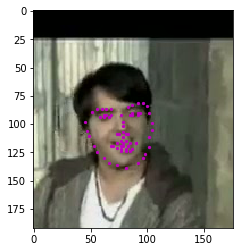

In [9]:
image = mpimg.imread(os.path.join('data/training/', image_name))
print(image.shape)

def plot_face_keypoints(image, keypoints):
    plt.imshow(image)
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, marker='.', c='m')

plot_face_keypoints(image, keypoints)

In [10]:
# Adapted from: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

class FacialKeypointsDataset(Dataset):
    def __init__(self, csv_file, path_base, transform=None):
        self.keypoints_frame = pd.read_csv(csv_file)
        self.path_base = path_base
        self.transform = transform
        
    def __len__(self):
        return len(self.keypoints_frame)
    
    # read images here instead of init to save memory
    def __getitem__(self, idx):
        """
        Returns a dictionary of:
        {"image": image, "keypoints": keypoints}
        """
        
        image_name = self.keypoints_frame.iloc[idx, 0]
        image = mpimg.imread(os.path.join(self.path_base, image_name))
        
        # if image has an alpha color channel (4th), get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
            
        keypoints = self.keypoints_frame.iloc[idx, 1:]
        # change from pandas series to numpy array, reshape to (num_keypoints, 2)
        keypoints = keypoints.to_numpy().astype('float').reshape(-1, 2)
        
        sample = {"image": image, "keypoints": keypoints}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
        

In [11]:
data_train = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                   path_base='data/training/')

print("No of training data: ", len(data_train))

No of training data:  3462


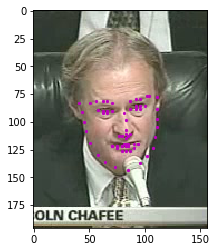

In [12]:
sample = data_train[1]
plot_face_keypoints(sample['image'], sample['keypoints'])

In [13]:
for idx in range(5):
    sample = data_train[idx]
    print("Image shape: ", sample['image'].shape)

Image shape:  (192, 176, 3)
Image shape:  (196, 157, 3)
Image shape:  (190, 170, 3)
Image shape:  (240, 213, 3)
Image shape:  (191, 184, 3)


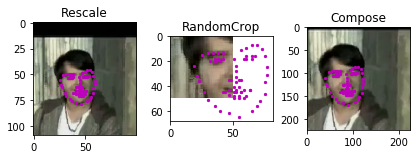

In [14]:


# test out some of these transforms
rescale = Rescale(100)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

# apply the transforms to a sample image
sample = data_train[0]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    plot_face_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

In [26]:
from src.transform import Normalize, Rescale, RandomCrop, ToTensor

data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
train_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             path_base='data/training/',
                                             transform=data_transform)



test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             path_base='data/test/',
                                             transform=data_transform)


print("No. of training data: ", len(train_dataset))
print("No. of test data: ", len(test_dataset))

No. of training data:  3462
No. of test data:  770


In [27]:
# load training data in batches
batch_size = 64
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=1)

# load test data in batches
batch_size = 64
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=1)

In [31]:
from src.model import Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop4): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=43264, out_features=1000, bias=True)
  (drop5): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (drop6): Dropout(p=0.6, inplace=False)
  (fc3): Linear(in_features=10

In [32]:
criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

In [33]:
def validate_net(net, test_loader, criterion):
    # set model to eval mode to avoid applying dropout
    net.eval()

    # move model to GPU
    net.to("cuda")
    
    test_loss = 0
    
    for batch_i, data in enumerate(test_loader):
        images = data['image']
        key_pts = data['keypoints']
        
        # flatten pts
        key_pts = key_pts.view(key_pts.size(0), -1)

        # convert variables to floats for regression loss
        key_pts = key_pts.type(torch.FloatTensor)
        images = images.type(torch.FloatTensor)

        images = images.to('cuda')
        key_pts = key_pts.to('cuda')
        
        output_pts = net(images)
        
        loss = criterion(output_pts, key_pts)
        
        test_loss += loss.item()
        
    return test_loss
    
    

In [34]:
def train_net(n_epochs):

    # prepare the net for training
    #net.train()
    
    loss_over_time = []
    
    # move model to GPU
    net.to("cuda")

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']
            
            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            
            images = images.to('cuda')
            key_pts = key_pts.to('cuda')
            
            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 27 == 26:    # print every 27 batches
                
                net.eval()
                
                with torch.no_grad():
                    test_loss = validate_net(net, test_loader, criterion)
                
                training_loss = running_loss/27
                
                print('Epoch: {}/{},'.format(epoch+1, n_epochs),
                      'Batch: {},'.format(batch_i+1), 
                      'Training Loss: {:.3f}'.format(training_loss),
                      'Test Loss: {:.3f}'.format(test_loss/len(test_loader)))
                
                loss_over_time.append(running_loss/27)
                
                running_loss = 0.0
                
                net.train()

    print('Finished Training')
    
    return loss_over_time

In [36]:
# train your network
n_epochs = 10 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
training_loss = train_net(n_epochs)

Epoch: 1/10, Batch: 27, Training Loss: 0.093 Test Loss: 0.488
Epoch: 1/10, Batch: 54, Training Loss: 0.090 Test Loss: 0.302
Epoch: 2/10, Batch: 27, Training Loss: 0.090 Test Loss: 0.236
Epoch: 2/10, Batch: 54, Training Loss: 0.087 Test Loss: 0.166
Epoch: 3/10, Batch: 27, Training Loss: 0.083 Test Loss: 0.111
Epoch: 3/10, Batch: 54, Training Loss: 0.080 Test Loss: 0.095
Epoch: 4/10, Batch: 27, Training Loss: 0.082 Test Loss: 0.379
Epoch: 4/10, Batch: 54, Training Loss: 0.080 Test Loss: 0.092
Epoch: 5/10, Batch: 27, Training Loss: 0.074 Test Loss: 0.082
Epoch: 5/10, Batch: 54, Training Loss: 0.076 Test Loss: 0.158
Epoch: 6/10, Batch: 27, Training Loss: 0.070 Test Loss: 0.078
Epoch: 6/10, Batch: 54, Training Loss: 0.068 Test Loss: 0.142
Epoch: 7/10, Batch: 27, Training Loss: 0.070 Test Loss: 0.092
Epoch: 7/10, Batch: 54, Training Loss: 0.064 Test Loss: 0.071
Epoch: 8/10, Batch: 27, Training Loss: 0.070 Test Loss: 0.216
Epoch: 8/10, Batch: 54, Training Loss: 0.063 Test Loss: 0.059
Epoch: 9

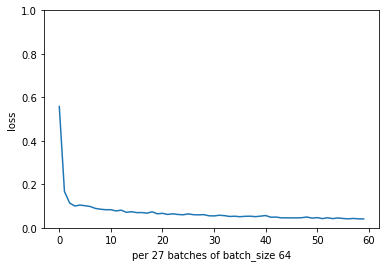

In [22]:
plt.plot(training_loss)
plt.xlabel('per 27 batches of batch_size 64')
plt.ylabel('loss')
plt.ylim(0, 1.0) # consistent scale
plt.show()

In [25]:
def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        
        images = images.to("cuda")
        key_pts = key_pts.to("cuda")

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

In [26]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

test_images = test_images.to("cpu")
test_outputs = test_outputs.to("cpu")
gt_pts = gt_pts.to("cpu")


# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


In [27]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


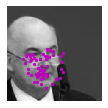

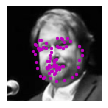

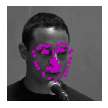

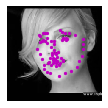

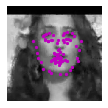

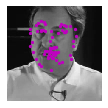

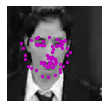

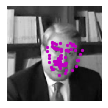

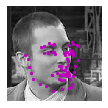

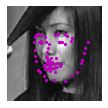

In [30]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    
    test_images = test_images.to("cpu")
    test_outputs = test_outputs.to("cpu")
    
    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs)

In [29]:
# model_dir = 'saved_models/'
# model_name = 'naimish_net_30epochs.pt'

# torch.save(net.state_dict(), model_dir+model_name)

In [37]:
net.load_state_dict(torch.load('saved_models/naimish_net_30epochs.pt'))

<All keys matched successfully>

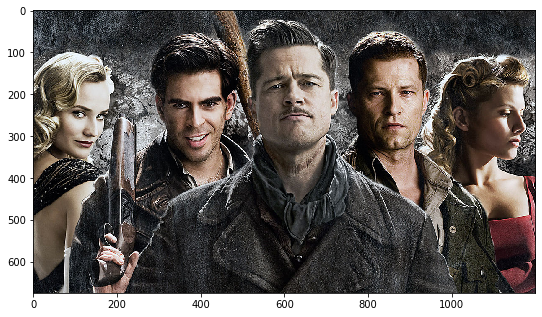

In [38]:
import cv2
# load in color image for face detection
image = cv2.imread('images/basterds.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

[[520  97 204 204]
 [775 129 177 177]
 [300 158 179 179]
 [ 57 187 167 167]]


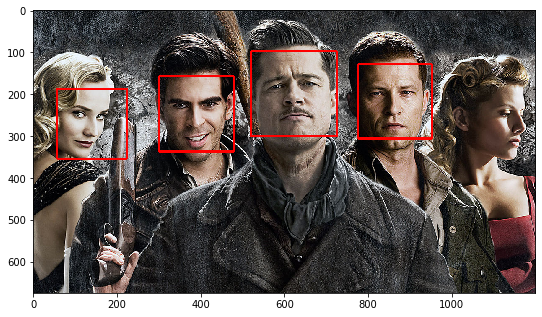

In [54]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

print(faces)

In [40]:
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop4): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=43264, out_features=1000, bias=True)
  (drop5): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (drop6): Dropout(p=0.6, inplace=False)
  (fc3): Linear(in_features=10

(224, 224)
(68, 2)
(224, 224)
(68, 2)
(224, 224)
(68, 2)
(224, 224)
(68, 2)


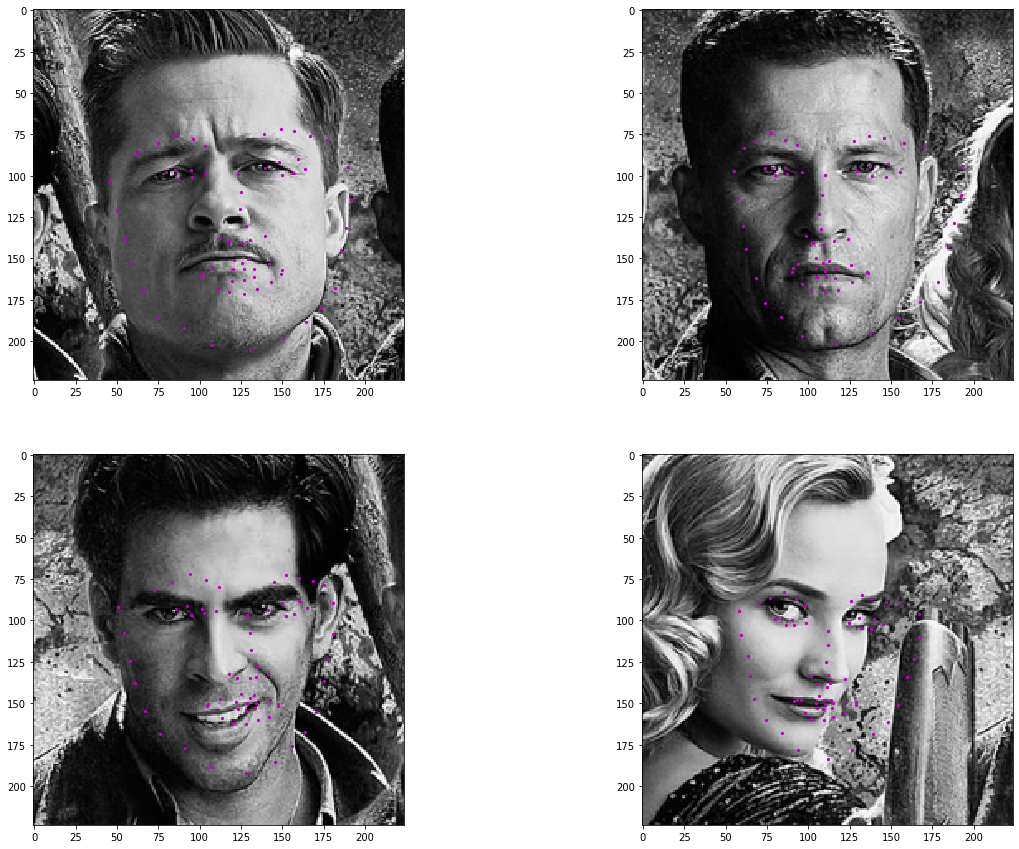

In [67]:
image_copy = np.copy(image)

# loop over the detected faces from your haar cascade
fig = plt.figure(figsize=(20,15))
for i, (x,y,w,h) in enumerate(faces):
    
    # Select the region of interest that is the face in the image
    pad = 50
    roi = image_copy[y-pad:y+h+pad, x-pad:x+w+pad]
    
    ## TODO: Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = roi/255.0
    
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    if h > w:
        new_h, new_w = 224* h / w, 224
    elif w > h:
        new_h, new_w = 224, 224* w / h
    else:
        new_h, new_w = 224, 224
    new_h, new_w = int(new_h), int(new_w)

    roi = cv2.resize(roi, (new_w, new_h))
    
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    # if image has no grayscale color channel, add one
    if(len(roi.shape) == 2):
        # add that third color dim
        roi_torch = roi.reshape(roi.shape[0], roi.shape[1], 1, 1)
        
    roi_torch = roi_torch.transpose((3, 2, 0, 1))
    roi_torch = torch.from_numpy(roi_torch)
    
    # convert images to FloatTensors
    roi_torch = roi_torch.type(torch.FloatTensor)
    #print(roi.size())
    
    roi_torch = roi_torch.to("cuda")
    
    ## TODO: Make facial keypoint predictions using your loaded, trained network
    output_pts = net(roi_torch)
    
    output_pts=output_pts.to("cpu")
    
    predicted_key_pts = output_pts.data
    predicted_key_pts = predicted_key_pts.numpy()
    
    #reshape to 68 x 2 pts
    predicted_key_pts = predicted_key_pts[0].reshape((68, 2))
    
    #undo normalization
    predicted_key_pts = predicted_key_pts*50.0+100
    

    ## TODO: Display each detected face and the corresponding keypoints        

    

    fig.add_subplot(2, 2, i+1)
    print(roi.shape)
    print(predicted_key_pts.shape)
    plt.imshow(roi, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    #plt.axis('off')


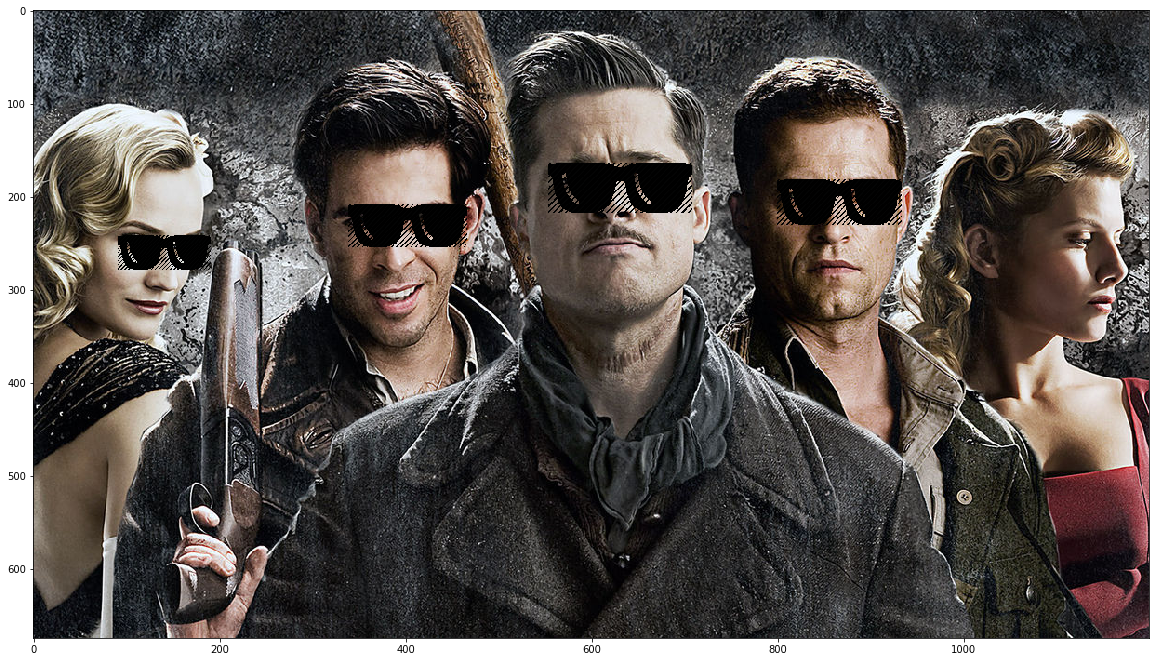

In [86]:
# loop over the detected faces from your haar cascade
fig = plt.figure(figsize=(20,15))

for i, (x,y,w,h) in enumerate(faces):
    
    # Select the region of interest that is the face in the image
    pad = 50
    roi = image_copy[y-pad:y+h+pad, x-pad:x+w+pad]
    
    ## TODO: Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = roi/255.0
    
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    if h > w:
        new_h, new_w = 224* h / w, 224
    elif w > h:
        new_h, new_w = 224, 224* w / h
    else:
        new_h, new_w = 224, 224
    new_h, new_w = int(new_h), int(new_w)

    roi = cv2.resize(roi, (new_w, new_h))
    
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    # if image has no grayscale color channel, add one
    if(len(roi.shape) == 2):
        # add that third color dim
        roi_torch = roi.reshape(roi.shape[0], roi.shape[1], 1, 1)
        
    roi_torch = roi_torch.transpose((3, 2, 0, 1))
    roi_torch = torch.from_numpy(roi_torch)
    
    # convert images to FloatTensors
    roi_torch = roi_torch.type(torch.FloatTensor)
    #print(roi.size())
    
    roi_torch = roi_torch.to("cuda")
    
    ## TODO: Make facial keypoint predictions using your loaded, trained network
    output_pts = net(roi_torch)
    
    output_pts=output_pts.to("cpu")
    
    predicted_key_pts = output_pts.data
    predicted_key_pts = predicted_key_pts.numpy()
    
    #reshape to 68 x 2 pts
    predicted_key_pts = predicted_key_pts[0].reshape((68, 2))
    
    #undo normalization
    predicted_key_pts = predicted_key_pts*50.0+100
    
    #correct for scaling and padding to original image format
    predicted_key_pts[:, 0] = predicted_key_pts[:, 0]*(w+2*pad)/new_w + x-pad
    predicted_key_pts[:, 1] = predicted_key_pts[:, 1]*(h+2*pad)/new_h + y-pad
    
    shades_x = int(predicted_key_pts[17, 0])
    shades_y = int(predicted_key_pts[17, 1])
    shades_h = int(abs(predicted_key_pts[27,1] - predicted_key_pts[34,1]))
    shades_w = int(abs(predicted_key_pts[17,0] - predicted_key_pts[26,0]))
    
    new_shades = cv2.resize(shades, (shades_w, shades_h), interpolation = cv2.INTER_CUBIC)

   # get region of interest on the face to change
    roi_color = image[shades_y:shades_y+shades_h,shades_x:shades_x+shades_w]
    
    ind = np.argwhere(new_shades[:,:,3] > 0)
    
    for i in range(3):
        roi_color[ind[:,0],ind[:,1],i] = new_shades[ind[:,0],ind[:,1],i]
    
    image[shades_y:shades_y+shades_h,shades_x:shades_x+shades_w] = roi_color

    ## TODO: Display each detected face and the corresponding keypoints        
    #plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    #plt.axis('off')

plt.imshow(image)

Image shape:  (171, 493, 4)


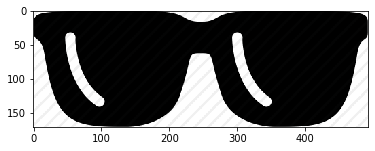

In [84]:
# load in sunglasses image with cv2 and IMREAD_UNCHANGED
shades = cv2.imread('images/shades.png', cv2.IMREAD_UNCHANGED)

# plot our image
plt.imshow(shades)

# print out its dimensions
print('Image shape: ', shades.shape)

The alpha channel looks like this (black pixels = transparent): 


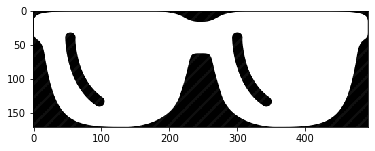

In [85]:
alpha_channel = shades[:,:,3]
print ('The alpha channel looks like this (black pixels = transparent): ')
plt.imshow(alpha_channel, cmap='gray')

In [83]:
values = np.where(alpha_channel != 0)
print ('The non-zero values of the alpha channel are: ')
print (values)

The non-zero values of the alpha channel are: 
(array([  1,   1,   1, ..., 511, 511, 511]), array([ 16,  17,  18, ..., 508, 509, 510]))
